In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
class ActivationFunction(Enum):
    ''' Enum of activation functions.
    '''
    Tanh = 0
    Sigmoid = 1
    Sin = 2
    Cos = 3
    Atan = 4

In [3]:
class ActivationFunctionNeuralNetwork(nn.Module):
    '''Activation function of the neural network.
    '''

    def __init__(self, activationFunction=ActivationFunction.Tanh):
        super(ActivationFunctionNeuralNetwork, self).__init__()
        self.activationFunction = activationFunction


    def forward(self, x):
        if self.activationFunction == ActivationFunction.Tanh:
            return torch.tanh(x)

        elif self.activationFunction == ActivationFunction.Sigmoid:
            return torch.sigmoid(x)

        elif self.activationFunction == ActivationFunction.Sin:
            return torch.sin(x)

        elif self.activationFunction == ActivationFunction.Cos:
            return torch.cos(x)

        elif self.activationFunction == ActivationFunction.Atan:
            return torch.atan(x)

In [129]:
class NeuralNet(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation.
    '''
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid):
        super(NeuralNet, self).__init__()
        self.layers = []
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.layers.append(ActivationFunctionNeuralNetwork(activationFunction))

        self.layers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self._normalInit)


    def _normalInit(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)


    def partialDerivative(self, x, order=1):
        grad = self.model(x)
        for i in range(order):
            grad = torch.autograd.grad(outputs=grad, inputs=x, grad_outputs=torch.ones_like(grad), create_graph=True)[0]
        
        return grad


    def train(self, feedDict, lossFunction, iterations, gradientDescent):
        # retrieve data
        xInt = torch.tensor(feedDict['xInt'], requires_grad=True).float()
        xBound = torch.tensor(feedDict['xBound'], requires_grad=True).float()
        yBoundCondition = torch.tensor(feedDict['yBoundCondition'])

        if gradientDescent:
            # Adam optimizer
            optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.01)

            for epoch in range(iterations):
                yInt = self.model(xInt)
                yBound = self.model(xBound)
                loss = lossFunction(xInt=xInt, yInt=yInt, yBound=yBound, yBoundCondition=yBoundCondition)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if epoch % 1000 == 0:
                    print('%d / %d, loss:%.2e' %(epoch, iterations, loss))

        else:
            # LBFGS optimizer
            optimizer = torch.optim.LBFGS(
                params=self.model.parameters(),
                lr=1,
                max_iter=iterations,
                max_eval=None,
                tolerance_grad=1e-07,
                tolerance_change=1e-09,
                history_size=100,
                line_search_fn=None
            )

            def closure():
                if torch.is_grad_enabled():
                    optimizer.zero_grad()
                yInt = self.model(xInt)
                yBound = self.model(xBound)
                loss = lossFunction(xInt, yInt, yBound, yBoundCondition)
                if loss.requires_grad:
                    loss.backward()
                return loss
            optimizer.step(closure)


    def predict(self, feedDict):
        xInt = torch.tensor(feedDict['xInt']).float()
        xBound = torch.tensor(feedDict['xBound']).float()

        outputInt = self.model(xInt)
        outputBound = self.model(xBound)

        return outputInt, outputBound

In [130]:
class PDENeuralNetwork():
    def __init__(self, domain, network):
        self.domain = domain
        self.network = network
        self.boundaryDomainSize, self.totalBoundaryDomainSize = self._computeBoundaryDomainSize()

    def _computeBoundaryDomainSize(self):
        boundaryDomainSize = []
        totalBoundaryDomainSize = 0
        for i in range(len(self.domain)):
            boundaryDomainSize.append(1)
            for j in range(len(self.domain)):
                if j != i:
                    boundaryDomainSize[i] = boundaryDomainSize[i] * (self.domain[j][1] - self.domain[j][0])
            totalBoundaryDomainSize = totalBoundaryDomainSize + 2 * boundaryDomainSize[i]
        
        return boundaryDomainSize, totalBoundaryDomainSize


    def sampleInteriorX(self, pointCount):
        if pointCount < 1:
            pointCount = 1

        xInt = []
        for i in range(len(self.domain)):
            xInt.append(np.random.uniform(low=self.domain[i][0], high=self.domain[i][1], size=(pointCount, 1)))
        
        return xInt

    # Sample uniform collocation points on the boundary of the domain
    def sampleBoundaryX(self, pointCount):
        if pointCount < 2 * len(self.domain):
            pointCount = 2 * len(self.domain)

        xBound = []

        # Iterate over dimensions
        for i in range(len(self.domain)):
            xBound.append(np.empty((0, 1), dtype=np.float64))

            # Iterate over boundaries
            for j in range(len(self.domain)):
                for bound in self.domain[j]:
                    newPoints = max(int(pointCount * self.boundaryDomainSize[j] / self.totalBoundaryDomainSize), 1)
                    if j == i:
                        newX = np.full((newPoints, 1), bound, dtype=np.float64)
                    else:
                        newX = np.random.uniform(low=self.domain[j][0], high=self.domain[j][1], size=(newPoints, 1))
                    xBound[i] = np.concatenate((xBound[i], newX))

        return xBound

    def sampleData(self, interiorPointCount, boundaryPointCount):
        feedDict = {}

        xInt = self.sampleInteriorX(interiorPointCount)
        xBound = self.sampleBoundaryX(boundaryPointCount)
        yBoundCondition= self.boundaryCondition(xBound)

        feedDict['xInt'] = np.array(xInt)[:,:,0].T
        feedDict['xBound'] = np.array(xBound)[:,:,0].T
        feedDict['yBoundCondition'] = np.array(yBoundCondition)

        return feedDict


    def train(self, interiorPointCount, boundaryPointCount, lossWeight, iterations, gradientDescent=True):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        self.network.train(feedDict, self.defaultLoss, iterations, gradientDescent)


    def predict(self, interiorPointCount, boundaryPointCount, lossWeight):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        predictionInterior, predictionBound = self.network.predict(feedDict)

        # Analytical Solution
        self.analyticalInterior = self.analyticalSolution(feedDict['xInt'])
        self.analyticalBound = self.analyticalSolution(feedDict['xBound'])

        # Compute L2 error (not sure the sum of interior and boundary is what we need...)
        errorInt = np.sqrt(np.sum((self.analyticalInterior - predictionInterior.detach().numpy()) ** 2))
        errorBound = np.sqrt(np.sum((self.analyticalBound - predictionBound.detach().numpy()) ** 2))

        return errorInt + errorBound

In [131]:
class LaplaceBase(PDENeuralNetwork):
    def __init__(self, domain, network=None):
        PDENeuralNetwork.__init__(self, domain=domain, network=network)


    def defaultLoss(self, xInt, yInt, yBound, yBoundCondition):
        lossInt, lossBound = self.computeLossTerms(domain=self.domain, xInt=xInt, yInt=yInt, yBound=yBound, yBoundCondition=yBoundCondition)

        return self.lossWeight * lossInt + (1 - self.lossWeight) * lossBound


    def computeLossTerms(self, domain, xInt, yInt, yBound, yBoundCondition):
        gradients = network.partialDerivative(x=xInt, order=2)
        lossInt = torch.mean(torch.square(gradients))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound

In [132]:
class Laplace_2d(LaplaceBase):
    def __init__(self, frequency, lossWeight, network=None):
        domain = [(0, 1), (0, 1)]
        LaplaceBase.__init__(self, domain, network)
        self.frequency = frequency
        self.lossWeight = lossWeight


    def analyticalSolution(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)


    def boundaryCondition(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)

# Example

In [133]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.5
iterations = 20000

In [134]:
network = NeuralNet([2, 20, 1], ActivationFunction.Sigmoid)
laplace = Laplace_2d(frequency=2*np.pi, lossWeight=lossWeight, network=network)

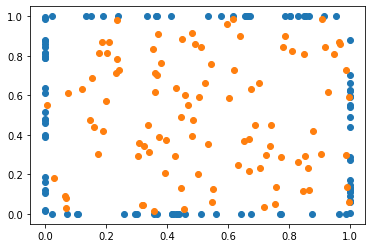

In [135]:
data = laplace.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,0], xBound[:,1] )
plt.scatter( xInt[:,0], xInt[:,1] );

## Adam optimizer

In [136]:
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 20000, loss:3.82e-01
1000 / 20000, loss:4.94e-02
2000 / 20000, loss:3.05e-02
3000 / 20000, loss:2.74e-02
4000 / 20000, loss:2.72e-02
5000 / 20000, loss:2.71e-02
6000 / 20000, loss:2.71e-02
7000 / 20000, loss:2.71e-02
8000 / 20000, loss:2.72e-02
9000 / 20000, loss:2.70e-02
10000 / 20000, loss:2.70e-02
11000 / 20000, loss:2.70e-02
12000 / 20000, loss:2.70e-02
13000 / 20000, loss:2.70e-02
14000 / 20000, loss:2.70e-02
15000 / 20000, loss:2.70e-02
16000 / 20000, loss:2.70e-02
17000 / 20000, loss:2.70e-02
18000 / 20000, loss:2.70e-02
19000 / 20000, loss:2.70e-02


In [137]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

6.70280935664654

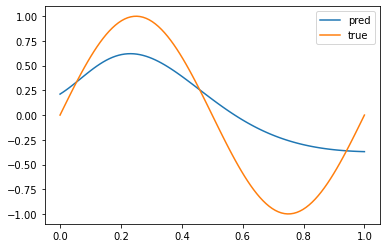

In [138]:
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

## LBFGS optimizer

In [139]:
laplace = Laplace_2d(frequency=2*np.pi, lossWeight=lossWeight, network=network)
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations,gradientDescent=False)

In [140]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

7.479046987271888

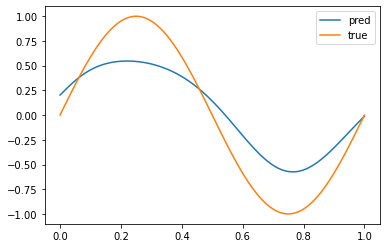

In [141]:
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();